# Advanced Lane Finding Project

This notebook contains the code to superimpose a visual cue for the road lane and a numerical estimation of its curvature and vehicle position.

The steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [2]:
%matplotlib inline

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pickle

# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [3]:
# constants and helpers

np.random.seed(54321)

show_images = False

nx = 9
ny = 6

# transform points by eyeball.
srcpoints = np.float32([[270,670],[592,450],[691,450],[1041,670]])
dstpoints = np.float32([[270,670],[270,100],[1041,100],[1041,670]])
imgshape = (720,1280)


# window settings for sliding windows
window_width = 50
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching


def get_cam_calib():
    with open('cam_calib.p','rb') as f:
        data = pickle.load(f)
        assert data is not None
        return data


## Compute the camera calibration using chessboard images

In [6]:

def camera_calibration(directory='camera_cal', show_images=3):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(directory + '/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        print('.', end='')
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            if show_images > 0 and np.random.uniform() < .5:
                show_images -= 1
                plt.imshow(img)
                plt.show()
    print()
    return objpoints, imgpoints

if show_imagesdo_tests:
    cam_calib = camera_calibration()

    with open('cam_calib.p','wb') as f:
        pickle.dump(cam_calib, f)
    
# objpoints, imgpoints = get_cam_calib()

## Undistort and Transform Perspective

In [7]:
def corners_unwarp(img, mtx, dist):
    # undistort
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx,ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M


In [8]:
def _test_calibration():
    img = cv2.imread('camera_cal/calibration10.jpg')
    objpoints, imgpoints = get_cam_calib()

    # Camera calibration, given object points, image points, and the shape of the grayscale image:
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)

    top_down, perspective_M = corners_unwarp(img, mtx, dist)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(top_down)
    ax2.set_title('Undistorted and Warped Image', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

if show_imagesdo_tests:
    _test_calibration()


## Preprocessing for Lane detection

In [9]:

def transform_perspective(img, srcpoints, dstpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1], gray.shape[0])
    # print(img_size)
    M = cv2.getPerspectiveTransform(srcpoints, dstpoints)
    warped = cv2.warpPerspective(img, M, img_size)
    return warped


def _test_transform_perspective():
    objpoints, imgpoints = get_cam_calib()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imgshape, None, None)

    files = glob.glob('test_images' + '/str*.jpg')
    for imgfile in files:
        imgori = cv2.imread(imgfile)
        imgori = cv2.cvtColor(imgori, cv2.COLOR_BGR2RGB)

        undist = cv2.undistort(imgori, mtx, dist, None, mtx)
        img = transform_perspective(undist, srcpoints, dstpoints)

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(imgori)
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(img)
        ax2.set_title('Undistorted and Warped Image', fontsize=30)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

if show_imagesdo_tests:
    _test_transform_perspective()



## Thresholded image


In [10]:

def thresholded(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary

def _test_thresholded():
    files = glob.glob('test_images' + '/str*.jpg')
    for imgfile in files:
        imgori = cv2.imread(imgfile)
        imgori = cv2.cvtColor(imgori, cv2.COLOR_BGR2RGB)

        undist = cv2.undistort(imgori, mtx, dist, None, mtx)
        img = transform_perspective(undist, srcpoints, dstpoints)

        img = thresholded(img)

        # Plot the result
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(imgori)
        ax1.set_title('Original Image', fontsize=40)
        ax2.imshow(img)
        ax2.set_title('Thresholded Result', fontsize=40)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

if show_images:
    _test_thresholded()


## Centroids using Sliding Window

In [11]:

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height) : int(img_ref.shape[0]-level*height),
           max(0, int(center-width/2)) : min(int(center+width/2), img_ref.shape[1])] = 1
    return output


def find_window_centroids(warped, window_width, window_height, margin):

    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions

    # First find the two starting positions for the left and right lane by using np.sum to get the
    # vertical image slice
    # and then np.convolve the vertical image slice with the window template 

    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)

    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))

    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum( warped[
            int(warped.shape[0]-(level+1)*window_height) : int(warped.shape[0]-level*window_height),
            :], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of
        # window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids


def centroids(warped):
    # print(warped.shape)
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows    
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channle 
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window     pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road       pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with  window results

    # If no window centers found, just display orginal road image
    else:
        print('no window centers')
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    return output


def merge_colors(img):
    bw = np.float32([img.shape[0],img.shape[1]])
    bw = img[:,:,0] + img[:,:,1] + img[:,:,2]
    return bw

def _test_centroids():
    objpoints, imgpoints = get_cam_calib()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imgshape, None, None)

    testfiles = [ 'straight_lines1', 'test2', 'test3']
    files = [ 'test_images/'+f+'.jpg' for f in testfiles ]
    for imgfile in files:
        print(imgfile)

        imgori = cv2.imread(imgfile)
        imgori = cv2.cvtColor(imgori, cv2.COLOR_BGR2RGB)

        undist = cv2.undistort(imgori, mtx, dist, None, mtx)
        img = transform_perspective(undist, srcpoints, dstpoints)

        img = thresholded(img)
        
        bw = merge_colors(img)
        img = centroids(bw)

        # Plot the result
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(imgori)
        ax1.set_title('Original Image', fontsize=40)
        ax2.imshow(img)
        ax2.set_title('Centroids Result', fontsize=40)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

if show_images:
    _test_centroids()

## Curvature

test_images/straight_lines1.jpg


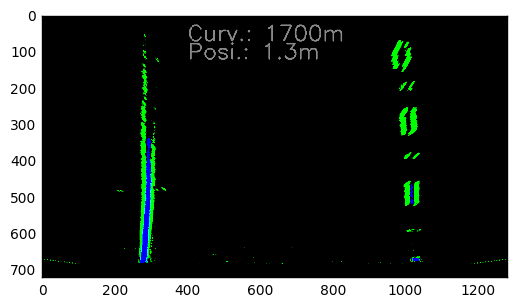

test_images/test2.jpg


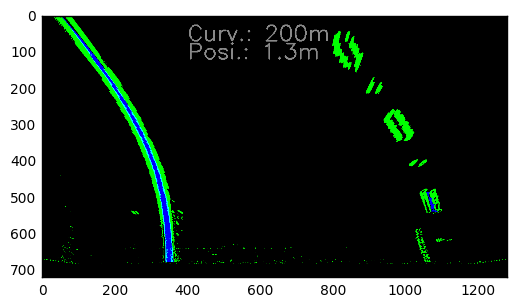

test_images/test3.jpg


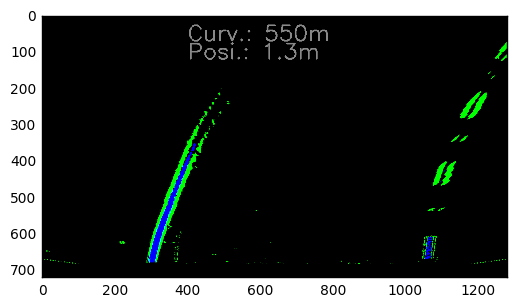

In [26]:
def fit_poly(centroids):
    # print(centroids)

    leftx = []
    rightx = []
    ys = []
    # Go through each level and draw the windows    
    for level in range(len(centroids)):
        leftx.append(centroids[level][0])
        rightx.append(centroids[level][1])
        y = imgshape[0] - (level * window_height + window_height / 2)
        ys.append(imgshape[0] - (level * window_height + window_height / 2))

    leftx = np.array(leftx)
    rightx = np.array(rightx)
    ys = np.array(ys)
    
    # Fit a second order polynomial to pixel positions
    left_fit = np.polyfit(ys, leftx, 2)
    right_fit = np.polyfit(ys, rightx, 2)

    return left_fit, right_fit, leftx, rightx, ys

def curvature(left_fit, right_fit, leftx, rightx, ys):
    y_eval = np.max(ys)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    # print(left_curverad, right_curverad)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ys*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ys*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    return left_curverad, right_curverad
    

def position(left_fit, right_fit, leftx, rightx, ys):
    return 1.3345

def round_curvature(l_c, r_c):
    c = (l_c + r_c) / 2
    if c > 1000:
        return (c // 100) * 100
    else:
        return (c // 50) * 50

def _test_curvature():
    objpoints, imgpoints = get_cam_calib()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imgshape, None, None)

    testfiles = [ 'straight_lines1', 'test2', 'test3']
    files = [ 'test_images/'+f+'.jpg' for f in testfiles ]
    for imgfile in files:
        print(imgfile)

        imgori = cv2.imread(imgfile)
        imgori = cv2.cvtColor(imgori, cv2.COLOR_BGR2RGB)

        undist = cv2.undistort(imgori, mtx, dist, None, mtx)
        img = transform_perspective(undist, srcpoints, dstpoints)

        img = thresholded(img)

        bw = merge_colors(img)
        window_centroids = find_window_centroids(bw, window_width, window_height, margin)
        l_fit, r_fit, lxs, rxs, ys = fit_poly(window_centroids)
        l_curve, r_curve = curvature(l_fit, r_fit, lxs, rxs, ys)
        car_pos = position(l_fit, r_fit, lxs, rxs, ys)

        # Add texts
        msg1 = "Curv.: %.0fm" % round_curvature(l_curve, r_curve)
        msg2 = "Posi.: %.1fm" % car_pos
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, msg1,(400,70), font, 2,(120,120,120),3)
        cv2.putText(img, msg2,(400,120), font, 2,(120,120,120),3)
        #Display the image
        plt.imshow(img)
        plt.show()

if True or show_images:
    _test_curvature()


## Drawing

test_images/straight_lines1.jpg


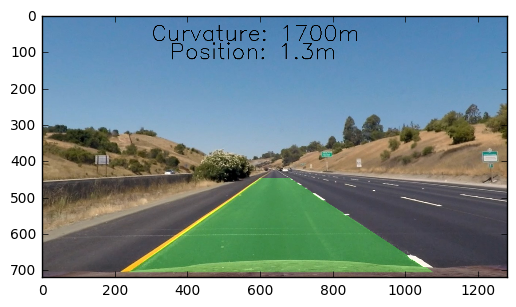

test_images/test2.jpg


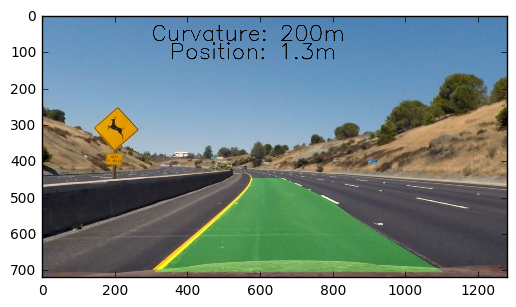

test_images/test3.jpg


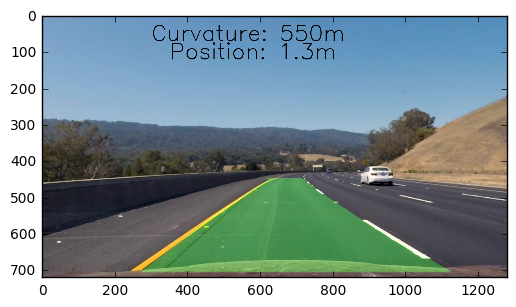

In [31]:

def draw(undist, warped, left_fitx, right_fitx, ploty, l_curve, r_curve, car_pos):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    Minv = cv2.getPerspectiveTransform(dstpoints, srcpoints)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (imgshape[1],imgshape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    # Add texts
    msg1 = "Curvature: %.0fm" % round_curvature(l_curve, r_curve)
    msg2 = "Position: %.1fm" % car_pos
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, msg1,(300,70), font, 2,(0,0,0),2)
    cv2.putText(result, msg2,(350,120), font, 2,(0,0,0),2)

    #msg = "%.0fm" % ((l_curve + r_curve) / 2)
    #font = cv2.FONT_HERSHEY_SIMPLEX
    #cv2.putText(result, msg,(500,100), font, 2,(0,0,0),2)

    return result


def _test_draw():
    objpoints, imgpoints = get_cam_calib()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imgshape, None, None)

    testfiles = [ 'straight_lines1', 'test2', 'test3']
    files = [ 'test_images/'+f+'.jpg' for f in testfiles ]
    for imgfile in files:
        print(imgfile)

        imgori = cv2.imread(imgfile)
        imgori = cv2.cvtColor(imgori, cv2.COLOR_BGR2RGB)

        undist = cv2.undistort(imgori, mtx, dist, None, mtx)
        img = transform_perspective(undist, srcpoints, dstpoints)
        img = thresholded(img)
 
        bw = merge_colors(img)
        window_centroids = find_window_centroids(bw, window_width, window_height, margin)
        l_fit, r_fit, lxs, rxs, ys = fit_poly(window_centroids)
        l_curve, r_curve = curvature(l_fit, r_fit, lxs, rxs, ys)
        car_pos = position(l_fit, r_fit, lxs, rxs, ys)

        result = draw(undist, bw, lxs, rxs, ys, l_curve, r_curve, car_pos)
        
        plt.imshow(result)
        plt.show()

if True or show_images:
    _test_draw()

## Pipeline

In [17]:

def calibrate_camera():
    objpoints, imgpoints = get_cam_calib()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imgshape, None, None)
    return mtx, dist

def pipeline(imgori, mtx, dist):
    imgori = cv2.cvtColor(imgori, cv2.COLOR_BGR2RGB)

    undist = cv2.undistort(imgori, mtx, dist, None, mtx)
    img = transform_perspective(undist, srcpoints, dstpoints)
    img = thresholded(img)

    bw = merge_colors(img)
    window_centroids = find_window_centroids(bw, window_width, window_height, margin)
    l_fit, r_fit, lxs, rxs, ys = fit_poly(window_centroids)
    l_curve, r_curve = curvature(l_fit, r_fit, lxs, rxs, ys)

    result = draw(undist, bw, lxs, rxs, ys, l_curve, r_curve)
    return result

params = {}

def process_image(img):
    return pipeline(img, **params)

def _test_pipeline():
    mtx, dist = calibrate_camera()
    params['mtx'] = mtx
    params['dist'] = dist
    
    files = glob.glob('test_images' + '/test[1-3].jpg')
    for imgfile in files:
        print(imgfile)

        imgori = cv2.imread(imgfile)
        result = process_image(imgori)
        
        plt.imshow(result)
        plt.show()


if show_images:
    _test_pipeline()


## Process video.


In [16]:
output_clip = 'advanced_lane.mp4'
clip1 = VideoFileClip("project_video.mp4")
advanced_lane = clip1.fl_image(process_image)
%time advanced_lane.write_videofile(output_clip, audio=False)


[MoviePy] >>>> Building video advanced_lane.mp4
[MoviePy] Writing video advanced_lane.mp4


100%|█████████▉| 1260/1261 [07:49<00:00,  2.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: advanced_lane.mp4 

CPU times: user 6min 31s, sys: 56.5 s, total: 7min 28s
Wall time: 7min 53s
